In [1]:
# 2d case

### Utils

In [2]:
import os
import typing
import re

import numpy
import scipy
import scipy.sparse
import scipy.io
from matplotlib import colors


def xy_to_id(x: int, y: int, nelx: int, nely: int, order: str = "F") -> int:
    """
    Map from 2D indices of a node to the flattened 1D index.

    The number of elements is (nelx x nely), and the number of nodes is
    (nelx + 1) x (nely + 1).

    Parameters
    ----------
    x:
        The x-coordinate of the node's positions.
    y:
        The y-coordinate of the node's positions.
    nelx:
        The number of elements in the x-direction.
    nely:
        The number of elements in the y-direction.
    order:
        The order of indecies. "F" for Fortran/column-major order and "C" for
        C/row-major order.

    Returns
    -------
        The index of the node in the flattened version.

    """
    if order == "C":
        return (y * (nelx + 1)) + x
    else:
        return (x * (nely + 1)) + y


def id_to_xy(index: int, nelx: int, nely: int, order: str = "F"
             ) -> typing.Tuple[int, int]:
    """
    Map from a 1D index to 2D indices of a node.

    The number of elements is (nelx x nely), and the number of nodes is
    (nelx + 1) x (nely + 1).

    Parameters
    ----------
    index:
        The 1D index to map to a 2D location.
    nelx:
        The number of elements in the x-direction.
    nely:
        The number of elements in the y-direction.
    order:
        The order of indecies. "F" for Fortran/column-major order and "C" for
        C/row-major order.

    Returns
    -------
        The index of the node in the flattened version.

    """
    if order == "C":
        y = index // (nelx + 1)
        x = index % (nelx + 1)
    else:
        x = index // (nely + 1)
        y = index % (nely + 1)
    return x, y


def deleterowcol(A: scipy.sparse.csc_matrix, delrow: numpy.ndarray,
                 delcol: numpy.ndarray) -> scipy.sparse.csc_matrix:
    """
    Delete the specified rows and columns from csc sparse matrix A.

    Assumes that matrix is in symmetric csc form!

    Parameters
    ----------
    A:
        Matrix
    delrow:
        Row indices to remove.
    delcol:
        Column indices to remove.

    Returns
    -------
        Matrix with rows and columns removed.

    """
    m = A.shape[0]
    keep = numpy.delete(numpy.arange(0, m), delrow)
    A = A[keep, :]
    keep = numpy.delete(numpy.arange(0, m), delcol)
    A = A[:, keep]
    return A


def squared_euclidean(x: numpy.ndarray) -> float:
    """
    Compute the squared euclidean length of x.

    Parameters
    ----------
    x:
        Vector to compute the squared norm of.

    Returns
    -------
        Squared norm of x = :math:`x^Tx`

    """
    return x.T.dot(x)

### BC

In [3]:
from abc import ABC, abstractmethod
class BoundaryConditions():
    """
    Abstract class for boundary conditions to a topology optimization problem.

    Functionalty for geting fixed nodes, forces, and passive elements.

    Attributes
    ----------
    nelx: int
        The number of elements in the x direction.
    nely: int
        The number of elements in the y direction.

    """

    def __init__(self, nelx: int, nely: int):
        """
        Create the boundary conditions with the size of the grid.

        Parameters
        ----------
        nelx:
            The number of elements in the x direction.
        nely:
            The number of elements in the y direction.

        """
        self.nelx = nelx
        self.nely = nely
        self.ndof = 2 * (nelx + 1) * (nely + 1)

    def __str__(self) -> str:
        """Construct a string representation of the boundary conditions."""
        return self.__class__.__name__

    def __format__(self, format_spec) -> str:
        """Construct a formated representation of the boundary conditions."""
        return str(self)

    def __repr__(self) -> str:
        """Construct a representation of the boundary conditions."""
        return "{}(nelx={:d}, nely={:d})".format(
            self.__class__.__name__, self.nelx, self.nely)

    @property
    @abstractmethod
    def fixed_nodes(self):
        """:obj:`numpy.ndarray`: Fixed nodes of the problem."""
        pass

    @property
    @abstractmethod
    def forces(self):
        """:obj:`numpy.ndarray`: Force vector for the problem."""
        pass

    @property
    def passive_elements(self):
        """:obj:`numpy.ndarray`: Passive elements to be set to zero density."""
        return numpy.array([])

    @property
    def active_elements(self):
        """:obj:`numpy.ndarray`: Active elements to be set to full density."""
        return numpy.array([])


class MBBBeamBoundaryConditions(BoundaryConditions):
    """Boundary conditions for the Messerschmitt–Bölkow–Blohm (MBB) beam."""

    @property
    def fixed_nodes(self):
        """:obj:`numpy.ndarray`: Fixed nodes in the bottom corners."""
        dofs = numpy.arange(self.ndof)
        fixed = numpy.union1d(dofs[0:2 * (self.nely + 1):2], numpy.array(
            [2 * (self.nelx + 1) * (self.nely + 1) - 1]))
        return fixed

    @property
    def forces(self):
        """:obj:`numpy.ndarray`: Force vector in the top center."""
        f = numpy.zeros((self.ndof, 1))
        f[1, 0] = -1
        return f


In [4]:
import torch
from torch import nn, autograd
class Unit(nn.Module):

    def __init__(self, in_N, out_N):
        super(Unit, self).__init__()
        self.in_N = in_N
        self.out_N = out_N
        self.L = nn.Linear(in_N, out_N)

    def forward(self, x):
        x1 = self.L(x)
        x2 = torch.tanh(x1)
        return x2


class NN1(nn.Module):

    def __init__(self, in_N, width, depth, out_N):
        super(NN1, self).__init__()
        self.width = width
        self.in_N = in_N
        self.out_N = out_N
        self.stack = nn.ModuleList()

        self.stack.append(Unit(in_N, width))

        for i in range(depth):
            self.stack.append(Unit(width, width))

        self.stack.append(nn.Linear(width, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x


class NN2(nn.Module):
    def __init__(self, in_N, width, depth, out_N):
        super(NN2, self).__init__()
        self.in_N = in_N
        self.width = width
        self.depth = depth
        self.out_N = out_N

        self.stack = nn.ModuleList()

        self.stack.append(nn.Linear(in_N, width))

        for i in range(depth):
            self.stack.append(nn.Linear(width, width))

        self.stack.append(nn.Linear(width, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)


### CELL

In [5]:
class MicroStruct:
    def __init__(self) -> None:
        pass
    def getCE_and_CEDrive(self):
        raise NotImplementedError('get_CE must be defined')


class Crossed_2D(MicroStruct):
    def __init__(self, model_L, model_Linear, model_noLinear) -> None:
        self.model_L = torch.load(model_L) 
        self.model_Linear = torch.load(model_Linear)  
        self.model_noLinear = torch.load(model_noLinear) 
        self.alpha = 0.5

    

    def getCE_and_CEDrive(self, x):
        x = np.asanyarray(x).reshape((-1,1))
        x = torch.from_numpy(x.reshape((-1, 1))).float().requires_grad_()
        alpha = self.alpha
        pred_L = self.model_L(x)
        pred_H = alpha * self.model_noLinear(torch.cat((x, pred_L), 1)) +\
              (1 - alpha) * self.model_Linear(torch.cat((x, pred_L), 1))

        dyh_dx = torch.ones_like(pred_H)
        for i in range(3):
            dx_i = autograd.grad(outputs=pred_H[:,i], inputs=x,
                        grad_outputs=torch.ones_like(pred_H[:,i]),
                          retain_graph=True)[0]
            dyh_dx[:,i] = dx_i[:,0]

        
        return pred_H, dyh_dx


    
    


In [6]:
import numpy as np
micro = Crossed_2D(model_L='model_L.pth',model_Linear='model_Linear.pth',model_noLinear='model_noLinear.pth')
x = np.array([0.5,0.3,0.2,0.4])
micro.getCE_and_CEDrive(x)

(tensor([[2.2457, 0.8586, 0.8867],
         [1.1517, 0.4942, 0.4577],
         [0.7290, 0.3236, 0.2926],
         [1.6520, 0.6730, 0.6535]], grad_fn=<AddBackward0>),
 tensor([[6.4861, 1.8888, 2.5529],
         [4.5955, 1.7505, 1.7965],
         [3.8733, 1.6567, 1.5124],
         [5.4365, 1.8232, 2.1302]]))

In [7]:
ce,ce_diff = micro.getCE_and_CEDrive(x)
ce = ce.detach().numpy()
ce

array([[2.2457461 , 0.85862243, 0.88665664],
       [1.1516771 , 0.49421668, 0.45772678],
       [0.7290148 , 0.32363248, 0.29259863],
       [1.652035  , 0.67301893, 0.65353936]], dtype=float32)

### PROBLEM

In [8]:
"""Topology optimization problem to solve."""
import abc
import numpy
import scipy.sparse
import scipy.sparse.linalg
import cvxopt
import cvxopt.cholmod

class Problem(abc.ABC):
    def __init__(self, bc: BoundaryConditions, micro: MicroStruct): 
        # Problem size
        self.nelx = bc.nelx
        self.nely = bc.nely
        self.nel = self.nelx * self.nely

        # Count degrees of fredom
        self.ndof = 2 * (self.nelx + 1) * (self.nely + 1)

        # microstructre 
        self.micro = micro

        # BC's and support (half MBB-beam)
        self.bc = bc
        dofs = numpy.arange(self.ndof)
        self.fixed = bc.fixed_nodes
        self.free = numpy.setdiff1d(dofs, self.fixed)

        # RHS and Solution vectors
        self.f = bc.forces
        self.u = numpy.zeros(self.f.shape)

        # Per element objective
        self.obje = numpy.zeros(self.nely * self.nelx)
        self.dobj = numpy.zeros(self.nely * self.nelx)
        # microStructure information 
        self.CE = None
        self.CE_Diff = None
        

    def __str__(self) -> str:
        """Create a string representation of the problem."""
        return self.__class__.__name__

    def __format__(self, format_spec) -> str:
        """Create a formated representation of the problem."""
        return str(self)

    def __repr__(self) -> str:
        """Create a representation of the problem."""
        return "{}(bc={!r})".format(
            self.__class__.__name__, self.bc)


    @abc.abstractmethod
    def compute_objective(
            self, xPhys: numpy.ndarray, dobj: numpy.ndarray) -> float:
        
        pass


class ElasticityProblem(Problem):
    def __init__(self, bc: BoundaryConditions, micro: MicroStruct):
       
        super().__init__(bc, micro)
        # Max and min stiffness
        self.Emin = 1e-9
        self.Emax = 1.0

        # FE: Build the index vectors for the for coo matrix format.
        self.nu = 0.3
        self.build_indices()

        # BC's and support (half MBB-beam)
        self.bc = bc
        dofs = numpy.arange(self.ndof)
        self.fixed = bc.fixed_nodes
        self.free = numpy.setdiff1d(dofs, self.fixed)

        # Number of loads
        self.nloads = self.f.shape[1]

    def build_indices(self) -> None:
        """Build the index vectors for the finite element coo matrix format."""
        self.edofMat = numpy.zeros((self.nelx * self.nely, 8), dtype=int)
        for elx in range(self.nelx):
            for ely in range(self.nely):
                el = ely + elx * self.nely # for the el-th element
                n1 = (self.nely + 1) * elx + ely # 左上角node
                n2 = (self.nely + 1) * (elx + 1) + ely # 右上角node
                self.edofMat[el, :] = numpy.array([
                    2 * n1 + 2, 2 * n1 + 3, 2 * n2 + 2, 2 * n2 + 3, 2 * n2,
                    2 * n2 + 1, 2 * n1, 2 * n1 + 1])
        # Construct the index pointers for the coo format
        self.iK = numpy.kron(self.edofMat, numpy.ones((8, 1), dtype=int)).flatten()
        self.jK = numpy.kron(self.edofMat, numpy.ones((1, 8), dtype=int)).flatten()

    def _updateConstitutiveInformation(self, xPhys: numpy.ndarray) -> None:
        ce, ce_diff = self.micro.getCE_and_CEDrive(xPhys)
        self.CE = ce.detach().numpy()
        self.CE_Diff = ce_diff.detach().numpy()

    def _gaussian_integral(self, CE):
        res = np.zeros((8, 8))
        L = np.array([[1, 0, 0, 0],
                       [0, 0, 0, 1],
                       [0, 1, 1, 0]])
        GN_x = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
        GN_y = GN_x.copy()
        GaussWeigh=[1, 1]
        dN = np.zeros((4, 8))
        for i in range(len(GN_x)):
            for j in range(len(GN_y)):
                x = GN_x[i]
                y = GN_y[j]
                dNx = 1/4 * np.array([-(1-y), (1-y), (1+y), -(1+y)])
                dNy = 1/4 * np.array([-(1-x), -(1+x), (1+x), (1-x)])
                dN[0,0:8:2] = dNx
                dN[1,0:8:2] = dNy
                dN[2,1:8:2] = dNx
                dN[3,1:8:2] = dNy
              
                Be = L @ dN
                res = res + GaussWeigh[i] * GaussWeigh[j] *(Be.T @ CE @ Be) 
        return res
    

    def _get_KE(self, CE_e):
        C11, C12, C33 = CE_e
        CE = np.array([[C11, C12, 0],
                       [C12, C11, 0],
                       [0, 0, C33]])
        
        return self._gaussian_integral(CE)

    def _get_DKE(self, CE_Diff_e):
        C11, C12, C33 = CE_Diff_e
        CE_Diff = np.array([[C11, C12, 0],
                       [C12, C11, 0],
                       [0, 0, C33]])
        return self._gaussian_integral(CE_Diff)
        
        

    def build_K(self, xPhys: numpy.ndarray, remove_constrained: bool = True
                ) -> scipy.sparse.coo_matrix:
        self._updateConstitutiveInformation(xPhys)
        sK = []
        for CE_e in self.CE:
            sK.append(self._get_KE(CE_e).flatten())
        sK = np.array(sK).flatten()
        K = scipy.sparse.coo_matrix(
            (sK, (self.iK, self.jK)), shape=(self.ndof, self.ndof))
        if remove_constrained:
            # Remove constrained dofs from matrix and convert to coo
            K = deleterowcol(K.tocsc(), self.fixed, self.fixed).tocoo()
        return K

        
      
    def compute_displacements(self, xPhys: numpy.ndarray) -> numpy.ndarray:
        K = self.build_K(xPhys)
        K = cvxopt.spmatrix(
            K.data, K.row, K.col)
       
        # Solve system
        F = cvxopt.matrix(self.f[self.free, :])
        cvxopt.cholmod.linsolve(K, F)  # F stores solution after solve
        new_u = self.u.copy()
        new_u[self.free, :] = numpy.array(F)[:, :]
        return new_u

    def update_displacements(self, xPhys: numpy.ndarray) -> None:
        self.u[:, :] = self.compute_displacements(xPhys)
       


class ComplianceProblem(ElasticityProblem):

    def compute_objective(self, xPhys: numpy.ndarray):
       # Setup and solve FE problem
        self.update_displacements(xPhys)

        obj = 0.0
        self.dobj[:] = 0.0
        for i in range(self.nloads):      
            ui = self.u[:, i][self.edofMat].reshape(-1, 8)
            for j in range(np.size(xPhys)):
                KE = self._get_KE(self.CE[j])
                DKE = self._get_DKE(self.CE_Diff[j])

                self.obje[j] = ui[j] @ KE @ ui[j] 
                self.dobj[j] = -1 * ui[j] @ DKE @ ui[j] 
                obj +=   self.obje[j]          
        self.dobj[j] /= float(self.nloads)
        return obj / float(self.nloads)



In [9]:
bc = MBBBeamBoundaryConditions(3,4)
micro = Crossed_2D(model_L='model_L.pth',model_Linear='model_Linear.pth',model_noLinear='model_noLinear.pth')
problem = ComplianceProblem(bc=bc, micro=micro)


In [10]:
x = np.random.random(12)
problem.compute_objective(x)

8.498764933055476

In [11]:
problem.obje

array([0.57720817, 0.08200922, 0.08455691, 0.25656763, 0.08288022,
       0.24429885, 0.0556192 , 0.13760539, 0.00904084, 0.07502527,
       0.58434188, 6.30961135])

In [12]:
problem.dobj

array([-1.44611988e+00, -2.40564378e-01, -2.50756911e-01, -1.01984616e+00,
       -2.76909491e-01, -1.12536228e+00, -7.07734297e-01, -3.99541950e-01,
       -2.43000026e-02, -2.54090170e-01, -1.67857711e+00, -4.79276321e+01])

### GUI

In [13]:
from matplotlib import colors
import matplotlib.cm as colormaps
import matplotlib.pyplot as plt

class GUI(object):
    """
    Graphics user interface of the topology optimization.

    Draws the outputs a topology optimization problem.
    """

    def __init__(self, problem, title=""):
        """
        Create a plot and draw the initial design.

        Args:
            problem (topopt.Problem): problem to visualize
            title (str): title of the plot
        """
        self.problem = problem
        self.title = title
        plt.ion()  # Ensure that redrawing is possible
        self.init_subplots()
        plt.xlabel(title)
        # self.fig.tight_layout()
        # self.plot_force_arrows()
   
        # self.fig.show()

    def __str__(self):
        """Create a string representation of the solver."""
        return self.__class__.__name__

    def __format__(self, format_spec):
        """Create a formated representation of the solver."""
        return str(self)

    def __repr__(self):
        """Create a representation of the solver."""
        return '{}(problem={!r}, title="{}")'.format(
                self.__class__.__name__, self.problem, self.title)

    def init_subplots(self):
        """Create the subplots."""
        self.fig, self.ax = plt.subplots()
        self.im = self.ax.imshow(
            -numpy.zeros((self.problem.nely, self.problem.nelx)), cmap='gray',
            interpolation='none', norm=colors.Normalize(vmin=-1, vmax=0))

    # def plot_force_arrows(self):
    #     """Add arrows to the plot for each force."""
    #     arrowprops = {"arrowstyle": "->", "connectionstyle": "arc3", "lw": "2",
    #                   "color": 0}
    #     nelx, nely, f = (self.problem.nelx, self.problem.nely, self.problem.f)
    #     cmap = plt.get_cmap("hsv", f.shape[1] + 1)
    #     for load_i in range(f.shape[1]):
    #         nz = numpy.nonzero(f[:, load_i])
    #         arrowprops["color"] = cmap(load_i)
    #         for i in range(nz[0].shape[0]):
    #             x, y = id_to_xy(nz[0][i] // 2, nelx, nely)
    #             x = max(min(x, nelx - 1), 0)
    #             y = max(min(y, nely - 1), 0)
    #             z = int(nz[0][i] % 2)
    #             mag = -50 * f[nz[0][i], load_i]
    #             self.ax.annotate(
    #                 "", xy=(x, y), xycoords="data",
    #                 xytext=(0 if z else mag, mag if z else 0),
    #                 textcoords="offset points", arrowprops=arrowprops)

    def update(self, xPhys, title=None):
        """Plot the results."""
        self.im.set_array(
            -xPhys.reshape((self.problem.nelx, self.problem.nely)).T)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        if title is not None:
            plt.title(title)
        plt.pause(0.01)




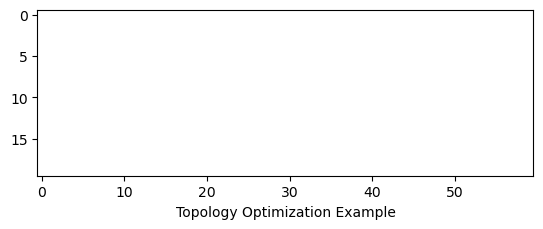

In [14]:
bc = MBBBeamBoundaryConditions(60,20)
micro = Crossed_2D(model_L='model_L.pth',model_Linear='model_Linear.pth',model_noLinear='model_noLinear.pth')
problem = ComplianceProblem(bc=bc, micro=micro)
gui = GUI(problem, "Topology Optimization Example")

### FILTER

In [54]:
class Filter(abc.ABC):
    """Filter solutions to topology optimization to avoid checker boarding."""

    def __init__(self, nelx: int, nely: int, rmin: float):
        """
        Create a filter to filter solutions.

        Build (and assemble) the index+data vectors for the coo matrix format.

        Parameters
        ----------
        nelx:
            The number of elements in the x direction.
        nely:
            The number of elements in the y direction.
        rmin:
            The filter radius.

        """
        # 88 lines matlab code
        self._repr_string = "{}(nelx={:d}, nely={:d}, rmin={:g})".format(
            self.__class__.__name__, nelx, nely, rmin)
        # (numpy.ceil(rmin) - 1) means half of the neighbor region radius (except itself)
        # so ''((2 * (numpy.ceil(rmin) - 1) + 1)**2)'' means the aera of the region
        nfilter = int(nelx * nely * ((2 * (numpy.ceil(rmin) - 1) + 1)**2))
        iH = numpy.zeros(nfilter)
        jH = numpy.zeros(nfilter)
        sH = numpy.zeros(nfilter)
        cc = 0
        for i in range(nelx):
            for j in range(nely):
                row = i * nely + j
                # neighbors of element at (i,j)
                kk1 = int(numpy.maximum(i - (numpy.ceil(rmin) - 1), 0))
                kk2 = int(numpy.minimum(i + numpy.ceil(rmin), nelx))
                ll1 = int(numpy.maximum(j - (numpy.ceil(rmin) - 1), 0))
                ll2 = int(numpy.minimum(j + numpy.ceil(rmin), nely))
                for k in range(kk1, kk2):
                    for l in range(ll1, ll2):
                        col = k * nely + l
                        fac = rmin - numpy.sqrt(
                            ((i - k) * (i - k) + (j - l) * (j - l)))
                        iH[cc] = row
                        jH[cc] = col
                        sH[cc] = numpy.maximum(0.0, fac)
                        cc = cc + 1
        # Finalize assembly and convert to csc format
        self.H = scipy.sparse.coo_matrix(
            (sH, (iH, jH)), shape=(nelx * nely, nelx * nely)).tocsc()
        self.Hs = self.H.sum(1)

    def __str__(self) -> str:
        """Create a string representation of the filter."""
        return self.__class__.__name__

    def __format__(self, format_spec) -> str:
        """Create a formated representation of the filter."""
        return str(self)

    def __repr__(self) -> str:
        """Create a formated representation of the filter."""
        return self._repr_string

    @abc.abstractmethod
    def filter_variables(self, x: numpy.ndarray, xPhys: numpy.ndarray) -> None:
        """
        Filter the variable of the solution to produce xPhys.

        Parameters
        ----------
        x:
            The raw density values.
        xPhys:
            The filtered density values to be computed

        """
        pass

    @abc.abstractmethod
    def filter_objective_sensitivities(
            self, xPhys: numpy.ndarray, dobj: numpy.ndarray) -> None:
        """
        Filter derivative of the objective.

        Parameters
        ----------
        xPhys:
            The filtered density values.
        dobj:
            The filtered objective sensitivities to be computed.

        """
        pass

    @abc.abstractmethod
    def filter_volume_sensitivities(
            self, xPhys: numpy.ndarray, dv: numpy.ndarray) -> None:
        """
        Filter derivative of the volume.

        Parameters
        ----------
        xPhys:
            The filtered density values.
        dv:
            The filtered volume sensitivities to be computed.

        """
        pass
        
class SensitivityBasedFilter(Filter):
    """Sensitivity based filter of solutions."""

    def filter_variables(self, x: numpy.ndarray, xPhys: numpy.ndarray) -> None:
        """
        Filter the variable of the solution to produce xPhys.

        Parameters
        ----------
        x:
            The raw density values.
        xPhys:
            The filtered density values to be computed

        """
        xPhys[:] = x

    def filter_objective_sensitivities(
            self, xPhys: numpy.ndarray, dobj: numpy.ndarray) -> None:
        """
        Filter derivative of the objective.

        Parameters
        ----------
        xPhys:
            The filtered density values.
        dobj:
            The filtered objective sensitivities to be computed.

        """
        dobj[:] = (numpy.asarray(
            (self.H * (xPhys * dobj))[numpy.newaxis].T / self.Hs)[:, 0] /
            numpy.maximum(0.001, xPhys))

    def filter_volume_sensitivities(
            self, xPhys: numpy.ndarray, dv: numpy.ndarray) -> None:
        """
        Filter derivative of the volume.

        Parameters
        ----------
        xPhys:
            The filtered density values.
        dv:
            The filtered volume sensitivities to be computed.

        """
        return

class DensityBasedFilter(Filter):
    """Density based filter of solutions."""

    def filter_variables(self, x: numpy.ndarray, xPhys: numpy.ndarray) -> None:
        """
        Filter the variable of the solution to produce xPhys.

        Parameters
        ----------
        x:
            The raw density values.
        xPhys:
            The filtered density values to be computed

        """
        xPhys[:] = numpy.asarray(self.H * x[numpy.newaxis].T / self.Hs)[:, 0]

    def filter_objective_sensitivities(
            self, xPhys: numpy.ndarray, dobj: numpy.ndarray) -> None:
        """
        Filter derivative of the objective.

        Parameters
        ----------
        xPhys:
            The filtered density values.
        dobj:
            The filtered objective sensitivities to be computed.

        """
        dobj[:] = numpy.asarray(
            self.H * (dobj[numpy.newaxis].T / self.Hs))[:, 0]

    def filter_volume_sensitivities(
            self, xPhys: numpy.ndarray, dv: numpy.ndarray) -> None:
        """
        Filter derivative of the volume.

        Parameters
        ----------
        xPhys:
            The filtered density values.
        dv:
            The filtered volume sensitivities to be computed.

        """
        dv[:] = numpy.asarray(self.H * (dv[numpy.newaxis].T / self.Hs))[:, 0]

In [55]:
filter = DensityBasedFilter(4, 3, 1.5)


In [56]:
x = np.random.random(12)
xPhys = np.zeros(12)
# xPhys[:] = numpy.asarray(self.H * x[numpy.newaxis].T / self.Hs)[:, 0]

In [57]:
filter.H

<12x12 sparse matrix of type '<class 'numpy.float64'>'
	with 70 stored elements in Compressed Sparse Column format>

### SOLVER

In [76]:
class TopOptSolver(abc.ABC):
    """Solver for topology optimization problems using NLopt's MMA solver."""

    def __init__(self, problem: Problem, volfrac: float, filter: Filter,
                 gui: GUI, maxeval=200, ftol_rel=1e-3):
        """
        Create a solver to solve the problem.

        Parameters
        ----------
        problem: :obj:`topopt.problems.Problem`
            The topology optimization problem to solve.
        volfrac: float
            The maximum fraction of the volume to use.
        filter: :obj:`topopt.filters.Filter`
            A filter for the solutions to reduce artefacts.
        gui: :obj:`topopt.guis.GUI`
            The graphical user interface to visualize intermediate results.
        maxeval: int
            The maximum number of evaluations to perform.
        ftol: float
            A floating point tolerance for relative change.

        """
        self.problem = problem
        self.filter = filter
        self.gui = gui
        n = problem.nelx * problem.nely
        self.xPhys = numpy.ones(n) * volfrac

        # set stopping criteria
        self.maxeval = maxeval
        self.ftol_rel = ftol_rel

        self.volfrac = volfrac  # max volume fraction to use

        # setup filter
        self.passive = problem.bc.passive_elements
        if self.passive.size > 0:
            self.xPhys[self.passive] = 0
        self.active = problem.bc.active_elements
        if self.active.size > 0:
            self.xPhys[self.active] = 1

    def __str__(self):
        """Create a string representation of the solver."""
        return self.__class__.__name__

    def __format__(self, format_spec):
        """Create a formated representation of the solver."""
        return "{} with {}".format(str(self.problem), str(self))

    def __repr__(self):
        """Create a representation of the solver."""
        return ("{}(problem={!r}, volfrac={:g}, filter={!r}, ".format(
            self.__class__.__name__, self.problem, self.volfrac, self.filter)
            + "gui={!r}, maxeval={:d}, ftol={:g})".format(
                self.gui, self.opt.get_maxeval(), self.opt.get_ftol_rel()))

    @abc.abstractmethod
    def optimize(self, x: numpy.ndarray) -> None: 
        pass


class OCSolver(TopOptSolver):

    def OC(self, x: numpy.ndarray, dobj: numpy.ndarray):
        minVF = 0.0
        maxVF = 1.
        l1 = 0
        l2 = 1e9
        move = 0.2
        xnew = np.zeros_like(self.xPhys)
        
        while (l2 - l1) / (l1 + l2) > 1e-3:
            lmid = 0.5*(l2 + l1)
            xnew[:] = np.maximum(minVF, np.maximum(x - move, np.minimum(maxVF, 
                    np.minimum(x + move, x * np.sqrt(-dobj / lmid)))))
            
            if np.sum(xnew) - self.volfrac * self.problem.nelx * self.problem.nely > 0:
                l1 = lmid
            else:
                l2 = lmid
        return xnew
       
    def optimize(self):
        it = 0
        rel_change = 1.
        while rel_change > self.ftol_rel and it < self.maxeval:
            xold = self.xPhys.copy()
            obj = self.problem.compute_objective(self.xPhys)
            self.filter.filter_objective_sensitivities(self.xPhys, self.problem.dobj)
            xnew = self.OC(xold, self.problem.dobj)
            
            rel_change = np.max(xnew-xold)
            vol = np.sum(xnew)/(self.problem.nelx * self.problem.nely)
            
            print(f' It.:{it}, Obj.:{obj}, Vol.:{vol} ch.:{rel_change}')
            self.xPhys[:] = xnew
            it += 1

        
        


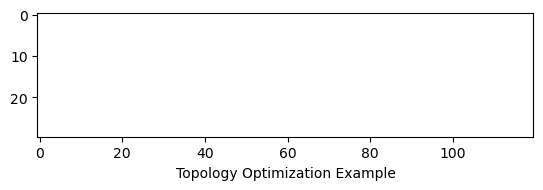

In [80]:
bc = MBBBeamBoundaryConditions(120,30)
micro = Crossed_2D(model_L='model_L.pth',model_Linear='model_Linear.pth',model_noLinear='model_noLinear.pth')
problem = ComplianceProblem(bc=bc, micro=micro)
gui = GUI(problem, "Topology Optimization Example")
topopt_filter = SensitivityBasedFilter(120, 30, 1.5)
solver = OCSolver(problem, 0.3, topopt_filter, gui)


In [81]:
solver.optimize()

 It.:0, Obj.:290.4374842877526, Vol.:0.30002030155125053 ch.:0.2
 It.:1, Obj.:171.5028087808794, Vol.:0.29998392376031235 ch.:0.19999999999999996
 It.:2, Obj.:127.40012317817434, Vol.:0.30010294961531536 ch.:0.20000000000000007
 It.:3, Obj.:96.82001287123137, Vol.:0.2999430734955463 ch.:0.20000000000000007
 It.:4, Obj.:77.08104478956827, Vol.:0.30007782557249335 ch.:0.20000000000000007
 It.:5, Obj.:73.03865697025321, Vol.:0.29991194175825237 ch.:0.19999999999999996
 It.:6, Obj.:71.50741004121637, Vol.:0.29997450223362004 ch.:0.1677431825489264
 It.:7, Obj.:70.73292362127057, Vol.:0.2999992105017519 ch.:0.17370549417180603
 It.:8, Obj.:70.51850878055052, Vol.:0.2999828330273238 ch.:0.1922662225300683
 It.:9, Obj.:70.2114687021836, Vol.:0.3000665964078761 ch.:0.19999999999999996
 It.:10, Obj.:70.12303295964229, Vol.:0.300108943959857 ch.:0.17648823447901874
 It.:11, Obj.:69.97140785529503, Vol.:0.29992168775314093 ch.:0.19300295748395924
 It.:12, Obj.:69.9360320282639, Vol.:0.29993622890

KeyboardInterrupt: 

In [79]:
solver.problem.CE

array([[9.98618  , 1.9987662, 3.9947543],
       [9.98618  , 1.9987662, 3.9947543],
       [3.0746317, 1.0771527, 1.2143935],
       ...,
       [8.738031 , 1.8238074, 3.4928832],
       [9.98618  , 1.9987662, 3.9947543],
       [9.98618  , 1.9987662, 3.9947543]], dtype=float32)

In [66]:
np.max(np.array([2,34,5,6,1]))

34

### TEST